Start of epoch 0
Training loss (batch) at step 0: mse: 161.24281311035156, topo: 1917560.0433637404, total:352.99884033203125
Start of epoch 1
Training loss (batch) at step 0: mse: 133.07603454589844, topo: 636139.2658615477, total:196.68995666503906
Start of epoch 2
Training loss (batch) at step 0: mse: 100.16650390625, topo: 317774.59003632434, total:131.9439697265625
Start of epoch 3
Training loss (batch) at step 0: mse: 88.83391571044922, topo: 319225.07275571604, total:120.75642395019531
Start of epoch 4
Training loss (batch) at step 0: mse: 85.0805892944336, topo: 307277.93810118665, total:115.80838012695312
Start of epoch 5
Training loss (batch) at step 0: mse: 83.59912872314453, topo: 382646.12881136965, total:121.86373901367188
Start of epoch 6
Training loss (batch) at step 0: mse: 61.0952262878418, topo: 249357.7174613481, total:86.03099822998047
Start of epoch 7
Training loss (batch) at step 0: mse: 69.09639739990234, topo: 383382.84238801704, total:107.43467712402344
Start 

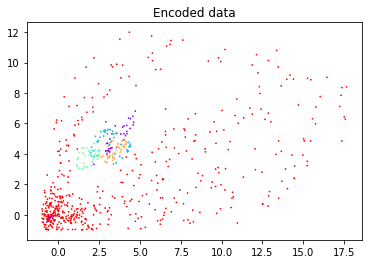

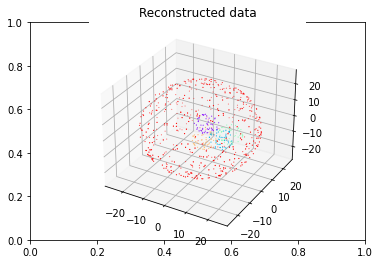

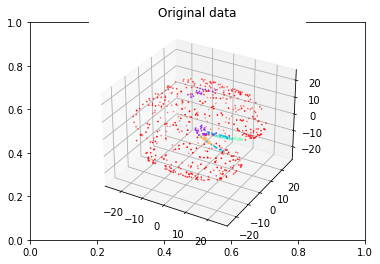

<Figure size 432x288 with 0 Axes>

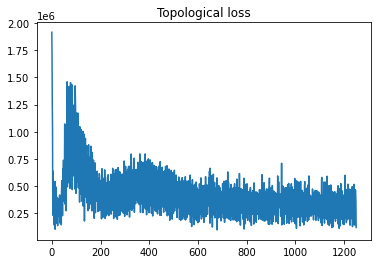

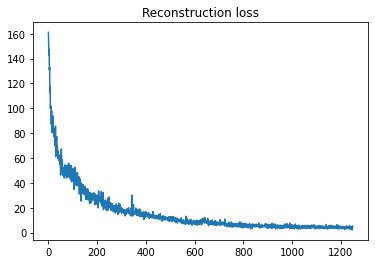

In [7]:
#%%

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Layer, Input
from tensorflow.keras import losses, Input
from tensorflow.keras import backend as K

from spheres import  create_sphere_dataset

from topolearn.util import make_shells
from topolearn.simpcomplex import RipsComplex
from topolearn.loss import  TopologicalLoss

X, y = create_sphere_dataset(n_samples=50, d=2, n_spheres=5)

# Dimension of the original space
input_dim = X.shape[1]
# Dimension of the latent space (encoding space)
latent_dim = 2
#y, X = make_shells(4000, input_dim, noise=0.01)


# Autoencoder  model
encoder = Sequential(
    [
        Input(shape=(input_dim,)),
        Dense(256, activation="elu"),
        Dense(128, activation="elu"),
        Dense(64, activation="elu"),
        Dense(32, activation="elu"),
        Dense(latent_dim, activation="elu"),
    ]
)
decoder = Sequential(
    [
        Dense(64, activation="elu", input_shape=(latent_dim,)),
        Dense(128, activation="elu"),
        Dense(256, activation="elu"),
        Dense(input_dim, activation=None),
    ]
)
input_seq = encoder.input
output_seq = decoder(encoder.output)
model = Model(inputs=input_seq, outputs=output_seq)


# Training config
# Training config
epochs = 250
batch_size = 150
lambda_topo = 0.0001
learning_rate = 1e-3
#
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_mse = keras.losses.MeanSquaredError()
topoloss = TopologicalLoss(
    filtration=RipsComplex(max_dim=1, max_radius = 2, verbose=0),
)

losses_mse = []
losses_topo = []

train_dataset = X
train_dataset = tf.data.Dataset.from_tensor_slices((X, X))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

for epoch in range(epochs):
    print(f"Start of epoch {epoch}")
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            middle = encoder(x_batch_train, training=True)
            preds = decoder(middle, training=True)

            loss_accuracy = loss_mse(y_batch_train, preds)
            loss_topo = topoloss(x_batch_train, middle)
            loss_value = loss_accuracy + lambda_topo * loss_topo

        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        losses_mse.append(loss_accuracy)
        losses_topo.append(loss_topo)

        if step % 200 == 0:
            print(
                f"Training loss (batch) at step {step}: mse: {loss_accuracy}, topo: {loss_topo}, total:{loss_value}"
            )


encoded = encoder(X)

Xaut = model.predict(X)

# Plot, plot, plot
plt.figure()
plt.title("Encoded data")
plt.scatter(encoded[:, 0], encoded[:, 1], c=y, cmap="rainbow", s=0.5)

plt.figure()
plt.title("Reconstructed data")
ax = plt.axes(projection="3d")
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap="rainbow", linewidth=0.5, s=0.5)

plt.figure()
plt.title("Original data")
ax = plt.axes(projection="3d")
ax.scatter(Xaut[:, 0], Xaut[:, 1], Xaut[:, 2], c=y, cmap="rainbow", s=0.5)
plt.figure()

plt.figure()
plt.title("Topological loss")
plt.plot(losses_topo)

plt.figure()
plt.title("Reconstruction loss")
plt.plot(losses_mse)




